En primer lugar importamos las librerías necesarias

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Esto es una clase que encontré en github hecha en tensorflow para utilizar el algoritmo SOM.

In [3]:
class WTU(object):
    
    def __init__(self, m, n, dim, num_iterations, eta = 0.5, sigma = None):
        self._m = m
        self._n = n
        self._neighbourhood = []
        self._topography = []
        self._num_iterations = int(num_iterations) 
        self._learned = False
        self.dim = dim
        self.eta = float(eta)
        if sigma is None:
            sigma = max(m,n)/2.0
        else:
            sigma = float(sigma)
        self.sigma = sigma
        print('Network created with dimensions',m,n)
        self._W = tf.random.normal([m*n, dim], seed = 0)
        self._topography = np.array(list(self._neuron_location(m, n)))

    def training(self,x, i):
            m = self._m
            n= self._n 
            d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([x for i in range(m*n)]),2),1))
            self.WTU_idx = tf.argmin(d,0)
            slice_start = tf.pad(tf.reshape(self.WTU_idx, [1]),np.array([[0,1]]))
            self.WTU_loc = tf.reshape(tf.slice(self._topography, slice_start,[1,2]), [2])
            learning_rate = 1 - i/self._num_iterations
            _eta_new = self.eta * learning_rate
            _sigma_new = self.sigma * learning_rate
            distance_square = tf.reduce_sum(tf.pow(tf.subtract(
                self._topography, tf.stack([self.WTU_loc for i in range(m * n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.math.divide(tf.cast(
                distance_square, "float32"), tf.pow(_sigma_new, 2))))
            eta_into_Gamma = tf.multiply(_eta_new, neighbourhood_func)
            weight_multiplier = tf.stack([tf.tile(tf.slice(
                eta_into_Gamma, np.array([i]), np.array([1])), [self.dim])
                for i in range(m * n)])
            delta_W = tf.multiply(weight_multiplier,
                tf.subtract(tf.stack([x for i in range(m * n)]),self._W))
            new_W = self._W + delta_W
            self._W = new_W

    def fit(self, X):
        for i in range(self._num_iterations):
            for x in X:
                 self.training(x,i)
        centroid_grid = [[] for i in range(self._m)]
        self._Wts = list(self._W)
        self._locations = list(self._topography)
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._Wts[i])
        self._centroid_grid = centroid_grid
        self._learned = True
    
    def winner(self, x):
        idx = self.WTU_idx,self.WTU_loc
        return idx
             
    def _neuron_location(self,m,n):
        for i in range(m):
            for j in range(n):
                yield np.array([i,j])
                
    def get_centroids(self):
        if not self._learned:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid

    def map_vects(self, X):
        if not self._learned:
            raise ValueError("SOM not trained yet")
        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self._Wts))],
                            key=lambda x: np.linalg.norm(vect - self._Wts[x]))
            to_return.append(self._locations[min_index])
        return to_return

Con esta función simplemente normalizaremos los datos provenientes del archivo Iris.csv que importaremos en la siguiente celda.

In [5]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result.astype(np.float32)

Aquí importamos la librería Iris.csv descargada de Kaggle. Luego dividimos los datos entre los valores que enviaremos al algoritmo (sin las labels) y las labels por separado que luego usaremos para graficar.

Luego crearemos un objeto SOM y lo definiremos con un mapa de 30x30, le asignaremos 400 iteraciones y un sigma (para las gauseanas) igual a 10.

In [5]:
df = pd.read_csv('Iris.csv') 
data = normalize(df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]).values
name = df['Species'].values
n_dim = 4

som = WTU(30, 30, n_dim, 400, sigma=10.0)
som.fit(data)

Network created with dimensions 30 30


Finalmente extraeremos el mapa generado anteriormente con el objeto y lo graficaremos. También imprimiremos algunas etiquetas (no todas) sobre el mapa del mapa graficado para poder ver si las etiquetas se distribuyeron en función de la las posiciones en el mapa.

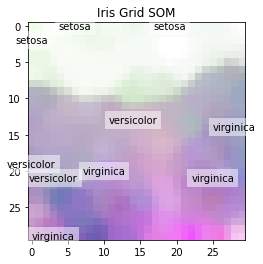

In [6]:
image_grid = som.get_centroids()
mapped = som.map_vects(data)
plt.imshow(image_grid)
plt.title('Iris Grid SOM')
c = 0
for i, m in enumerate(mapped):
    c = c+1
    if c % 15 == 0:
      plt.text(m[1], m[0], name[i][5:], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

Podemos observar cómo los datos con etiqueta 'setosa' se ubican en la parte superior del mapa. Los datos con etiqueta 'virginica' tienden a ubicarse en el otro extremo del mapa y finalmente los datos con etiqueta 'versicolor' tienen a ubicarse en posiciones intermedias.